# Conditions

In [23]:
import torch

if torch.cuda.is_available():
    device = "cuda:1"
else:
    device = "cpu"
print(device)

cuda:1


In [25]:
import torch, os
import torchvision.transforms as transforms
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import torchvision.datasets as datasets
import torch.utils.data as utils
from torchvision.utils import make_grid


### Preparation

#### 1. Data

In [3]:
data_transforms = [
    transforms.ToTensor(), # convert to the range [0,1]
    transforms.Lambda(lambda x: x * 2 - 1) # convert to the range [-1,1]
]
data_transforms = transforms.Compose(data_transforms)
data = datasets.MNIST("./mnist", download=False, transform=data_transforms)

In [4]:
batch_size = 128

# dataloaders
train_loader = utils.DataLoader(dataset=data, batch_size=batch_size, shuffle=True)

print("there are :", len(train_loader), "batches")

there are : 469 batches


#### 2. Model

This will be changed for each method (see below for more details).

#### 3. Scheduler

In [11]:
scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

#### 4. training loop

In [64]:
def train(epochs, net, data_loader, scheduler, use_cls=True):
    
    num_epochs = epochs

    net = net.to(device)

    loss_fn = nn.MSELoss()

    optim = torch.optim.Adam(net.parameters(), lr=1e-3)

    losses = []

    net.train()

    for e in range(num_epochs):

        for x, l in tqdm(data_loader):

            x = x.to(device)
            #l = l.to(device)

            z = torch.randn_like(x).to(device)

            ts = torch.randint(0, 1000, (x.shape[0], )).to(device)

            x_noisy = scheduler.add_noise(x, z, ts)

            if (use_cls):
                pred = net(x_noisy, ts, l).sample
            else:
                pred = net(x_noisy, ts).sample

            loss = loss_fn(pred, z)

            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())

        epoch_loss = sum(losses[-len(train_loader):]) / len(train_loader)
        print(f"Epoch {e} / {num_epochs} - loss: {epoch_loss:04f}")

    return losses

#### 5. Generate samples

In [94]:
def generate(net, scheduler, use_cls=True):

    x = torch.randn(100, 1, 28, 28).to(device)
    y = torch.tensor([[i]*10 for i in range(10)]).flatten().to(device)

    # Sampling loop
    for i, t in tqdm(enumerate(scheduler.timesteps)):

        # Get model pred
        with torch.no_grad():
            if (use_cls):
                pred = net(x, t, y).sample
            else:
                pred = net(x, t).sample

        # Update sample with step
        x = scheduler.step(pred, t, x).prev_sample

    # Show the results
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    ax.imshow(make_grid(x.detach().cpu().clip(-1, 1), nrow=10)[0], cmap='Greys')

### A. Inject condition into Unet

For this, we embed the class labels and concatenate the embeddings as to the image channels (in this case, our input channels become to 5 instead of 1). 

In [34]:
class ConditionalUNetL(nn.Module) :

    def __init__(self, num_class=10):

        super().__init__()

        self.unet = UNet2DModel(
            sample_size=28,
            in_channels=5,
            out_channels=1,
            layers_per_block=2,
            block_out_channels=(32, 64, 128),
            down_block_types=(
                "DownBlock2D",
                "AttnDownBlock2D",
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",
                "UpBlock2D",
            ),
        )

        self.num_class = num_class

        self.emb_class = nn.Embedding(num_class, 4)


    def forward(self, x, t, class_label):

        embs = self.emb_class(class_label) # (batch, 4)

        embs = embs.view(x.shape[0], 4, 1, 1).expand(-1, -1, x.shape[2], x.shape[3]) # (batch, 4) -> (batch, 4, 1, 1) -> (batch, 4, 28, 28)

        x = torch.cat((x, embs), dim=1) # (batch, 5, 28, 28)

        return self.unet(x, t).sample

#### 3. train

In [35]:
modelL = ConditionalUNetL().to(device)
LLosses = train(10, modelL, train_loader, scheduler)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 0 / 10 - loss: 0.080370


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1 / 10 - loss: 0.048247


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2 / 10 - loss: 0.044486


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3 / 10 - loss: 0.042910


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4 / 10 - loss: 0.042064


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5 / 10 - loss: 0.040951


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6 / 10 - loss: 0.040253


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7 / 10 - loss: 0.039882


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8 / 10 - loss: 0.039228


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9 / 10 - loss: 0.039149


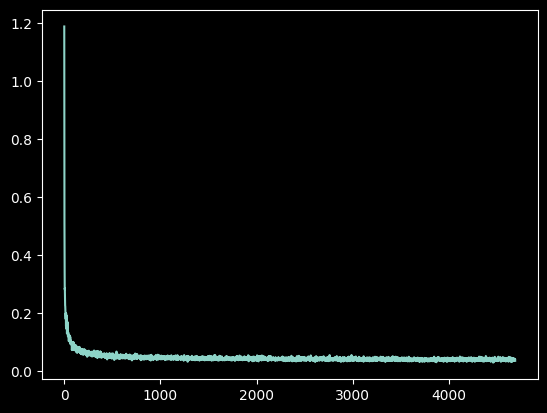

In [36]:
plt.plot(LLosses)

0it [00:00, ?it/s]

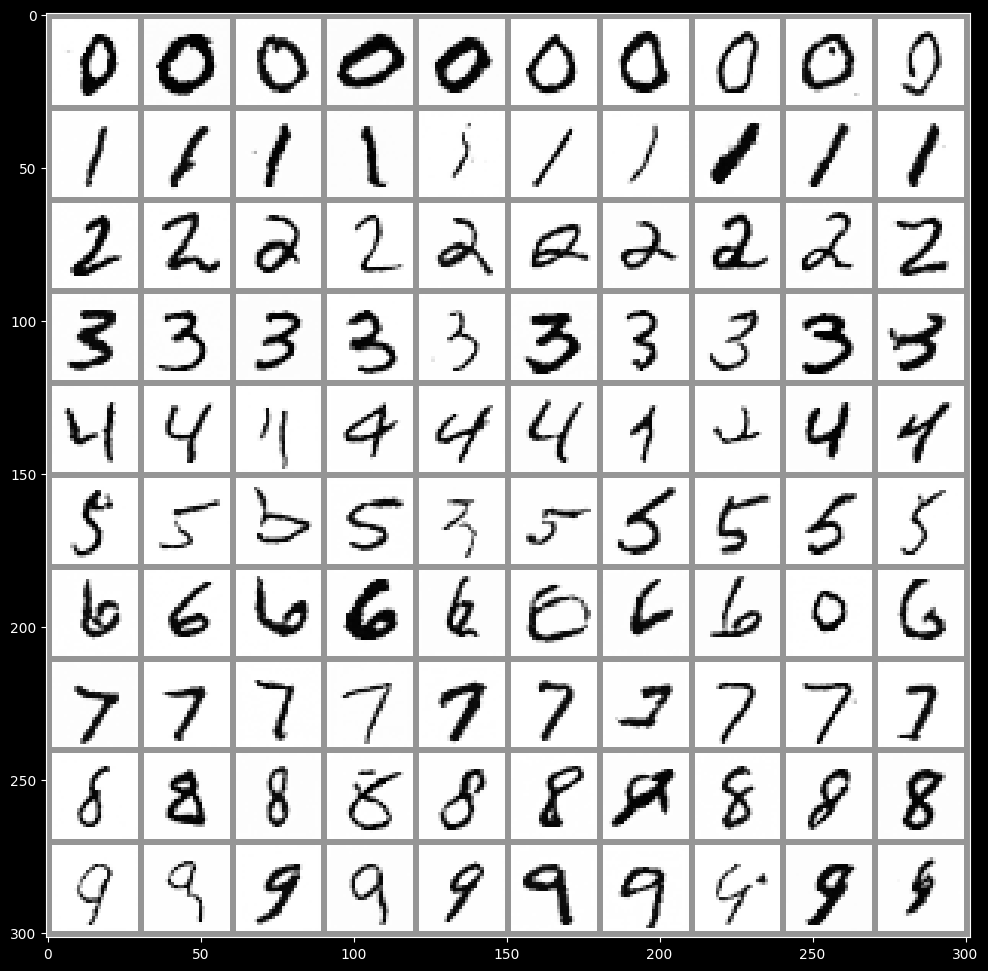

In [37]:
generate(modelL, scheduler)

### B. Inject into Resnet

In [38]:
from diffusers import UNet2DConditionModel

class ConditionalUNetT(nn.Module):

    def __init__(self, num_class=10):

        super().__init__()

        self.unet = UNet2DConditionModel(
            sample_size=28,
            in_channels=1,
            out_channels=1,
            layers_per_block=2,
            block_out_channels=(32, 64, 128),
            class_embed_type = None,
            num_class_embeds = 10,
            class_embeddings_concat = False,
            mid_block_type = "UNetMidBlock2D",
            down_block_types=(
                "DownBlock2D",
                "AttnDownBlock2D",
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",
                "UpBlock2D",
            ),
        )

        self.num_class = num_class

        self.emb_class = nn.Embedding(num_class, 4)


    def forward(self, x, t, class_label):

        return self.unet(x, t, encoder_hidden_states=None, class_labels=class_label).sample
    
modelT = ConditionalUNetT()

In [39]:
TLosses = train(10, modelT, train_loader, scheduler)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 0 / 10 - loss: 0.070331


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1 / 10 - loss: 0.046380


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2 / 10 - loss: 0.043776


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3 / 10 - loss: 0.042281


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4 / 10 - loss: 0.041550


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5 / 10 - loss: 0.040683


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6 / 10 - loss: 0.040054


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7 / 10 - loss: 0.039212


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8 / 10 - loss: 0.038819


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9 / 10 - loss: 0.038596


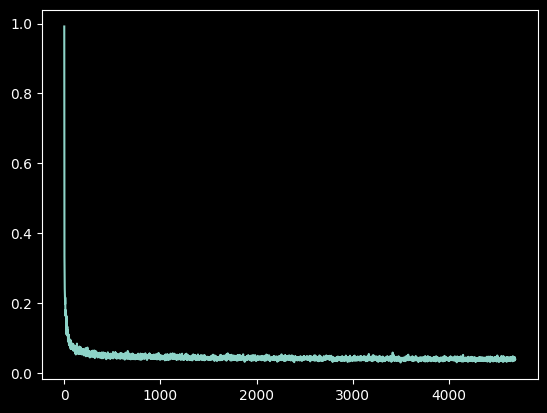

In [40]:
plt.plot(TLosses)

0it [00:00, ?it/s]

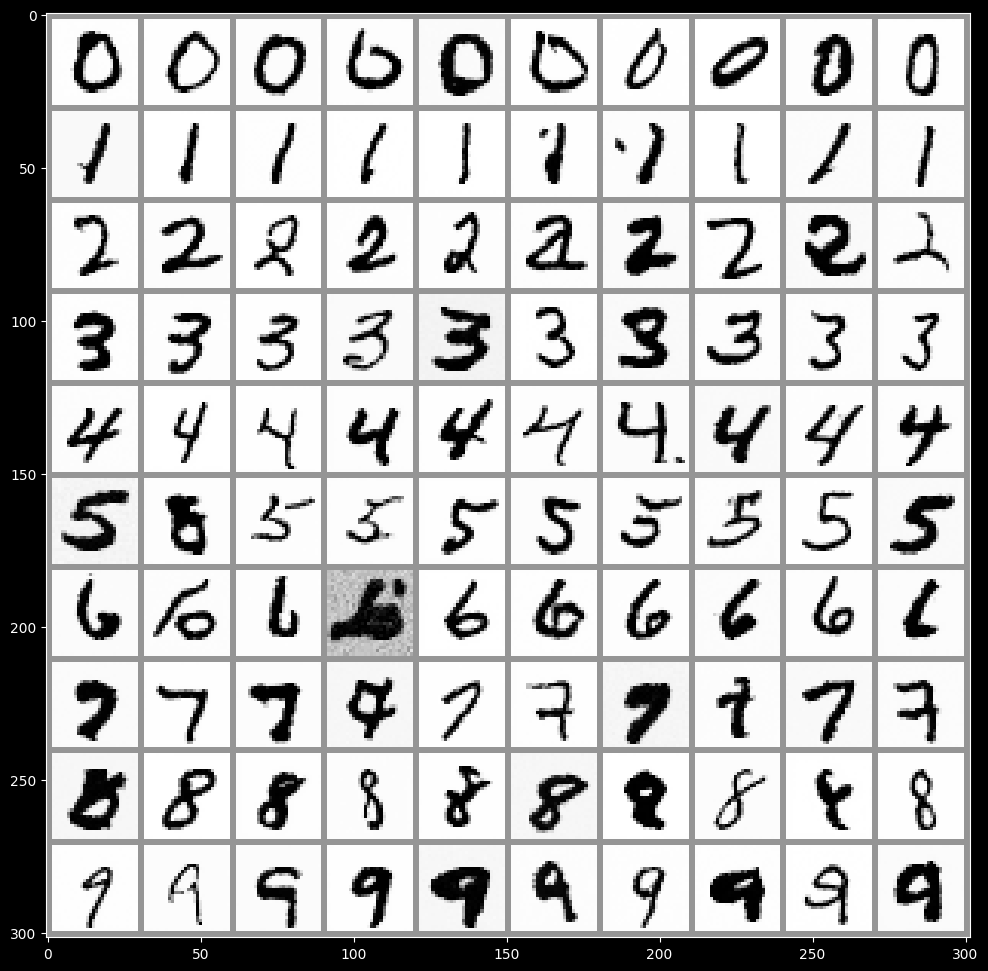

In [41]:
generate(modelT, scheduler)

### C. Inject into Transformer

We will transforms the label to a prompt and inject it to the transformer block as query.

In [45]:
ds = datasets.MNIST("./mnist", download=False)

In [46]:
# load dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from transformers import CLIPTokenizer, CLIPTextModel
from torchvision.datasets import MNIST
from torch.utils.data import Dataset

class MyMNISTDataset(Dataset):

    def __init__(self, dataset, tokenizer=None):
        # this returns a MNIST dataset
        # each item is a tuple (PIL_image, label)
        # self.dataset = datasets.MNIST("./mnist", download=False)
        self.dataset = dataset
        # self.tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
        self.tokenizer = tokenizer
        self.prompt = "a digit of "
        self.transforms = transforms.Compose([
            transforms.ToTensor(), # convert to the range [0,1]
            transforms.Lambda(lambda x: x * 2 - 1) # convert to the range [-1,1]
        ])

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        sample = {}
        img = self.dataset[idx][0] # PIL image
        # prompt = self.prompt + str(self.dataset[idx][1]) # label
        sample["image"] = self.transforms(img)
        # tokens = self.tokenizer(prompt, padding="max_length", truncation=True, max_length=512, return_tensors="pt").input_ids
        tokens =self.dataset[idx][1] # assume the digit is the token, so the dict size is 10
        sample["label"] = torch.as_tensor(tokens)
        return sample
    
mnist_dataset = MyMNISTDataset(ds)

In [47]:
# dataloader
import torch

def collate_fn(samples):
    imgs = [sample["image"] for sample in samples]
    imgs = torch.stack(imgs)
    imgs = imgs.to(memory_format=torch.contiguous_format).float()

    input_ids = [sample["label"] for sample in samples]
    input_ids = torch.stack(input_ids)
    input_ids = input_ids.to(memory_format=torch.contiguous_format).float()

    return {"images": imgs, "input_ids": input_ids}


train_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

In [18]:
# model

from diffusers import UNet2DConditionModel
from transformers import CLIPTokenizer, CLIPTextModel
import torch.nn as nn

class ConditionalUNetT(nn.Module):

    def __init__(self, num_class=10):

        super().__init__()
        # self.clip_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder")
        cross_attention_dim = 512
        self.embedding = torch.nn.Embedding(10, cross_attention_dim)

        self.unet = UNet2DConditionModel(
            sample_size=28,
            in_channels=1,
            out_channels=1,
            layers_per_block=2,
            block_out_channels=(32, 64, 128),
            class_embed_type = None,
            class_embeddings_concat = False,
            cross_attention_dim = cross_attention_dim,
            mid_block_type = "UNetMidBlock2D",
            down_block_types=(
                "DownBlock2D",
                "CrossAttnDownBlock2D",
                "CrossAttnDownBlock2D",
            ),
            up_block_types=(
                "CrossAttnUpBlock2D",
                "CrossAttnUpBlock2D",
                "UpBlock2D",
            ),
        )

    def forward(self, x, t, class_tokens):
        class_emb = self.embedding(class_tokens)[0]

        return self.unet(x, t, encoder_hidden_states=class_emb).sample
    
modelT = ConditionalUNetT()

In [20]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

In [43]:
# train

def train(epochs, net, data_loader, scheduler):
    
    num_epochs = epochs

    net = net.to(device)

    loss_fn = nn.MSELoss()

    optim = torch.optim.Adam(net.parameters(), lr=1e-3)

    losses = []

    net.train()

    for e in range(num_epochs):

        for batch in tqdm(data_loader):

            x = batch["images"].to(device)
            l = batch["input_ids"].to(device)

            z = torch.randn_like(x).to(device)

            ts = torch.randint(0, 1000, (x.shape[0], )).to(device)

            x_noisy = scheduler.add_noise(x, z, ts)

            pred = net(x_noisy, ts, l).sample

            loss = loss_fn(pred, z)

            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())

        epoch_loss = sum(losses[-len(train_loader):]) / len(train_loader)
        print(f"Epoch {e} / {num_epochs} - loss: {epoch_loss:04f}")

    return losses

In [44]:
TLosses = train(10, modelT, train_loader, scheduler)

  0%|          | 0/3750 [00:00<?, ?it/s]

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.cuda.FloatTensor instead (while checking arguments for embedding)

### D. Use Classifier Guidance

We need another nn for classification

In [8]:
# MNIST classifier net

class MNISTCLassifier(nn.Module):

    def __init__(self, num_class=10):
        super().__init__()
        self.num_class = num_class
        self.linear1 = nn.Linear(28*28, 512)
        self.linear2 = nn.Linear(512, 128)
        self.out = nn.Linear(128, num_class)
        self.drop = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.drop(x)
        x = self.out(x)
        return F.log_softmax(x, dim=1)

In [9]:
classifierPath = "/home/Qingyi/tmp/MNISTClassifier.pth"
classifier = MNISTCLassifier().to(device)

if os.path.exists(classifierPath):
    classifier.load_state_dict(torch.load(classifierPath))
else:
    # train classifier
    epochs = 50

    optim = torch.optim.SGD(classifier.parameters(), lr=1e-3)
    loss_fn = nn.NLLLoss()
    losses = []

    for e in range(epochs):
        for x, l in tqdm(train_loader):
            x = x.to(device)
            l = l.to(device)
            z = torch.randn_like(x).to(device)
            t = torch.randint(0, 1000, (x.shape[0], ))

            x_noisy = scheduler.add_noise(x, z, t)

            preds = classifier(x_noisy)
            loss = loss_fn(preds, l)

            optim.zero_grad()
            loss.backward()
            optim.step()

            losses.append(loss.item())

        print(f"Epoch {e} / {epochs} - loss: {sum(losses[-len(train_loader):]) / len(train_loader):04f}")

    torch.save(classifier.state_dict(), classifierPath)


ground truth:  tensor([3, 5, 5, 6, 7, 2, 0, 9, 9, 0])
predictions:  tensor([8, 5, 5, 6, 7, 2, 2, 9, 1, 2])


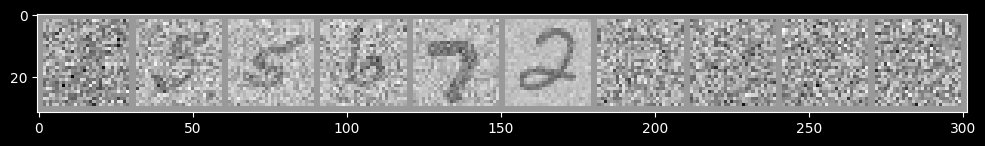

In [24]:
# tests

tests = next(iter(train_loader))
imgs = tests[0][:10]
labels = tests[1][:10]

z = torch.randn_like(imgs)
t = torch.randint(0, 1000, (imgs.shape[0], ))

imgs_noisy = scheduler.add_noise(imgs, z, t)
# imgs_noisy = imgs

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(make_grid(imgs_noisy, nrow=10)[0], cmap='Greys')

print("ground truth: ", labels)
print("predictions: ", torch.argmax(classifier(imgs_noisy.to(device)).cpu(), dim=1))



In [11]:
# train difuser model 
MNISTUNet = UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(32, 64, 128),
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "AttnUpBlock2D",
    ),
)

unetPath = "/home/Qingyi/tmp/MNISTUNet.pth"
MNISTUNet = MNISTUNet.to(device)
if os.path.exists(unetPath):
    MNISTUNet.load_state_dict(torch.load(unetPath))
else:
    MLosses = train(10, MNISTUNet, train_loader, scheduler, use_cls=False)
    torch.save(MNISTUNet.state_dict(), unetPath)

0it [00:00, ?it/s]

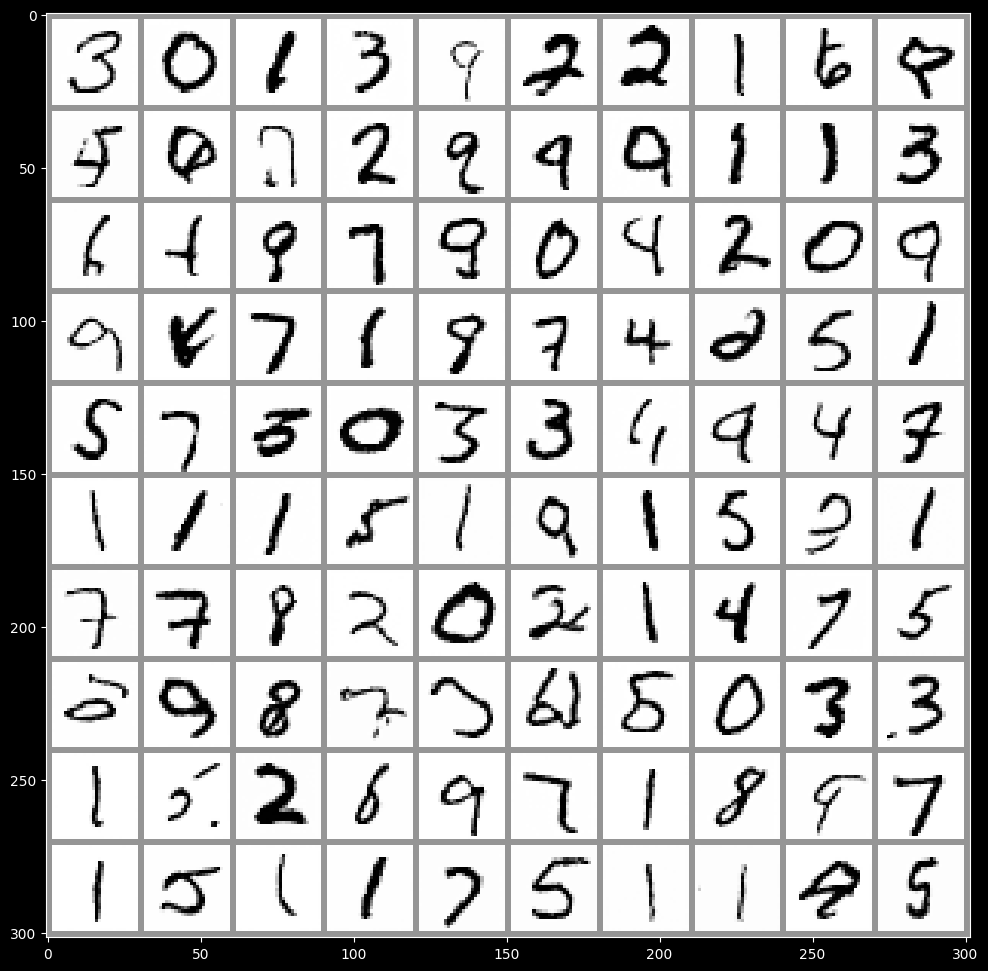

In [12]:
# tests
generate(MNISTUNet, scheduler, use_cls=False)

In [29]:
def get_classifier_gradient(x, target):
    classifier.zero_grad()
    x = x.clone().detach().requires_grad_()
    output = classifier(x)
    output[:,target].sum().backward()
    return x.grad.detach()

  0%|          | 0/10 [00:00<?, ?it/s]

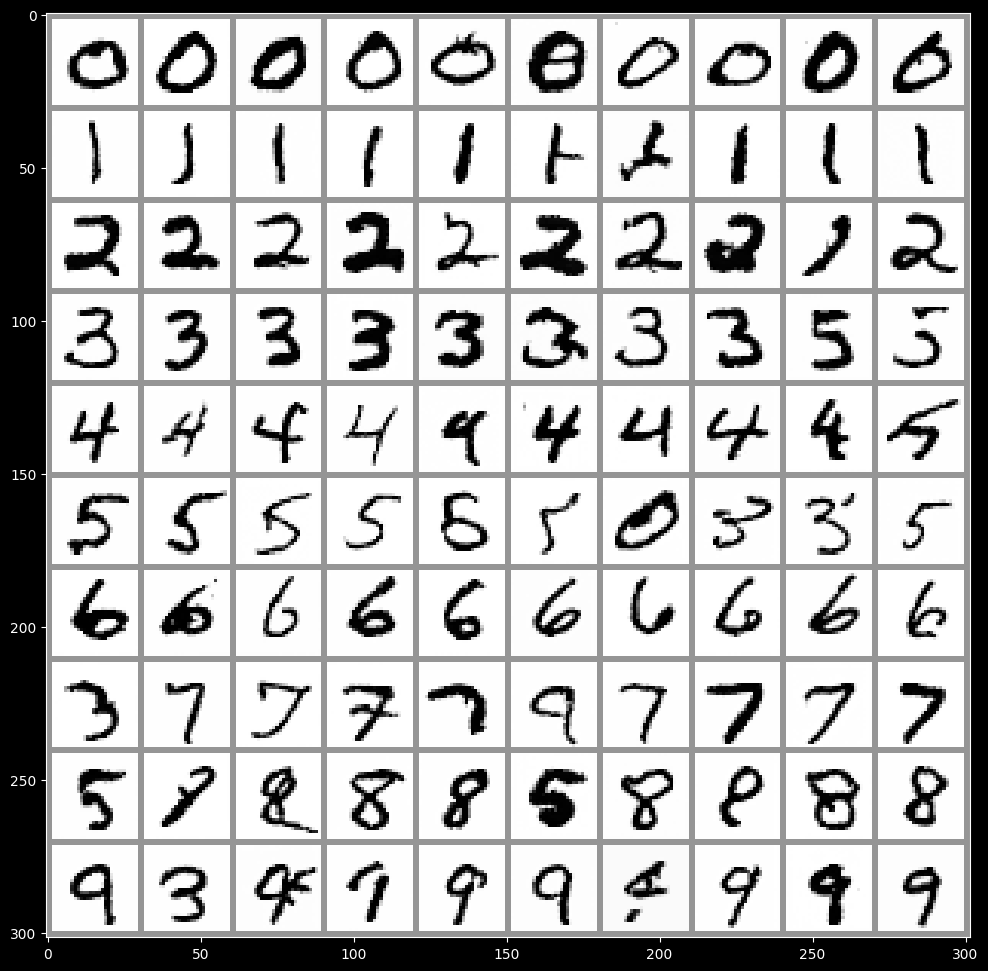

In [31]:
# sampling

guidance_scale = 7.5

outputs = torch.empty((100, 1, 28, 28))

# Sampling loop
for i in tqdm(range(10)):

    x = torch.randn(10, 1, 28, 28).to(device)
    y = torch.tensor([i]).flatten().to(device)
    
    for t in scheduler.timesteps:

        # Get model pred
        with torch.no_grad():
            pred = MNISTUNet(x, t).sample

        # Get guidance
        guidance = get_classifier_gradient(x, y)

        # Sample with guidance
        pred -= guidance * guidance_scale

        # Update sample with step
        x = scheduler.step(pred, t, x).prev_sample
    
    outputs[i*10: i*10+10,:,:,:] = x

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(make_grid(outputs.detach().cpu().clip(-1, 1), nrow=10)[0], cmap='Greys')



### E. Classifier-free Guidance

use text as guidance.
def classifier_free_guidance(model, x_t, t, y, guidance_scale):
    # Unconditional forward pass
    unconditional = model(x_t, t)
    
    # Conditional forward pass
    conditional = model(x_t, t, y)
    
    # Apply guidance
    return unconditional + guidance_scale * (conditional - unconditional)

In [2]:
# load CLIP model
from transformers import CLIPTextModel, CLIPTokenizer
ckp = "openai/clip-vit-base-patch32"
tokenizer = CLIPTokenizer.from_pretrained(ckp)
encoder = CLIPTextModel.from_pretrained(ckp)

/home/Qingyi/.local/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [5]:
# model
from diffusers import UNet2DConditionModel

class CLIPUNet(nn.Module):

    def __init__(self, tokenizer, encoder):

        super().__init__()

        self.unet = UNet2DConditionModel(
            sample_size=28,
            in_channels=1,
            out_channels=1,
            layers_per_block=2,
            block_out_channels=(32, 64, 64),
            cross_attention_dim=512,
            down_block_types=(
                "DownBlock2D",
                "CrossAttnDownBlock2D",
                "CrossAttnDownBlock2D",
            ),
            up_block_types=(
                "UpBlock2D",
                "CrossAttnUpBlock2D",
                "CrossAttnUpBlock2D",
            ),
        )

        self.tokenizer = tokenizer
        self.encoder = encoder

    def forward(self, x, t, y):
        samples = [f"a handwritten digit {l}" for l in y]
        # Encode text
        tokens = self.tokenizer(samples, padding="max_length", max_length=8, truncation=True, return_tensors="pt")
        
        text_inputs = self.encoder(tokens.input_ids.to(self.unet.device))[0]
        # Pass through U-Net
        return self.unet(x, t, encoder_hidden_states=text_inputs)
    
modelC = CLIPUNet(tokenizer, encoder)

In [8]:
# training
modelCPath = "/home/Qingyi/tmp/classifier_free.pth"
modelC = CLIPUNet(tokenizer, encoder)

if os.path.exists(modelCPath):
    modelC.load_state_dict(torch.load(modelCPath))
else:
    CLosses = train(10, modelC, train_loader, scheduler)
    torch.save(modelC.state_dict(), modelCPath)


0it [00:00, ?it/s]

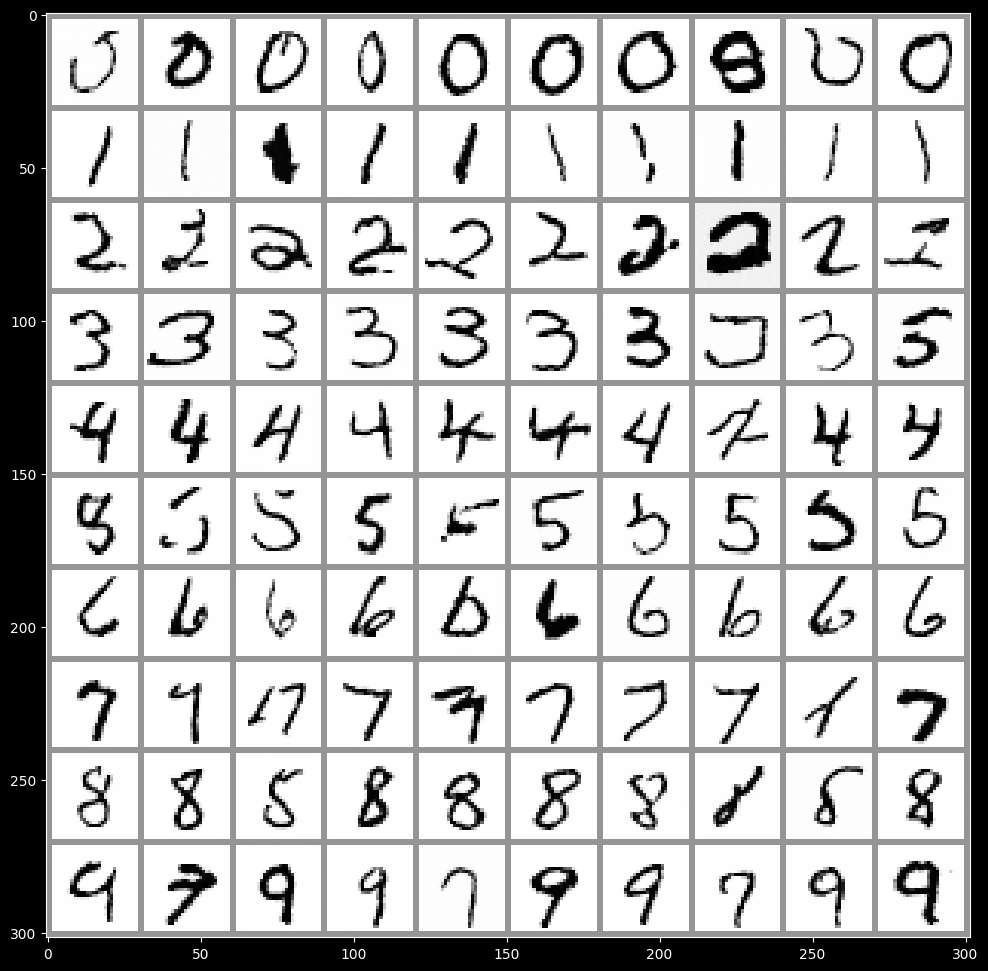

In [99]:
generate(modelC, scheduler)

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([20, 8, 512])


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([20, 8, 512])


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([20, 8, 512])


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([20, 8, 512])


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([20, 8, 512])


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([20, 8, 512])


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([20, 8, 512])


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([20, 8, 512])


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([20, 8, 512])


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([20, 8, 512])


  0%|          | 0/1000 [00:00<?, ?it/s]

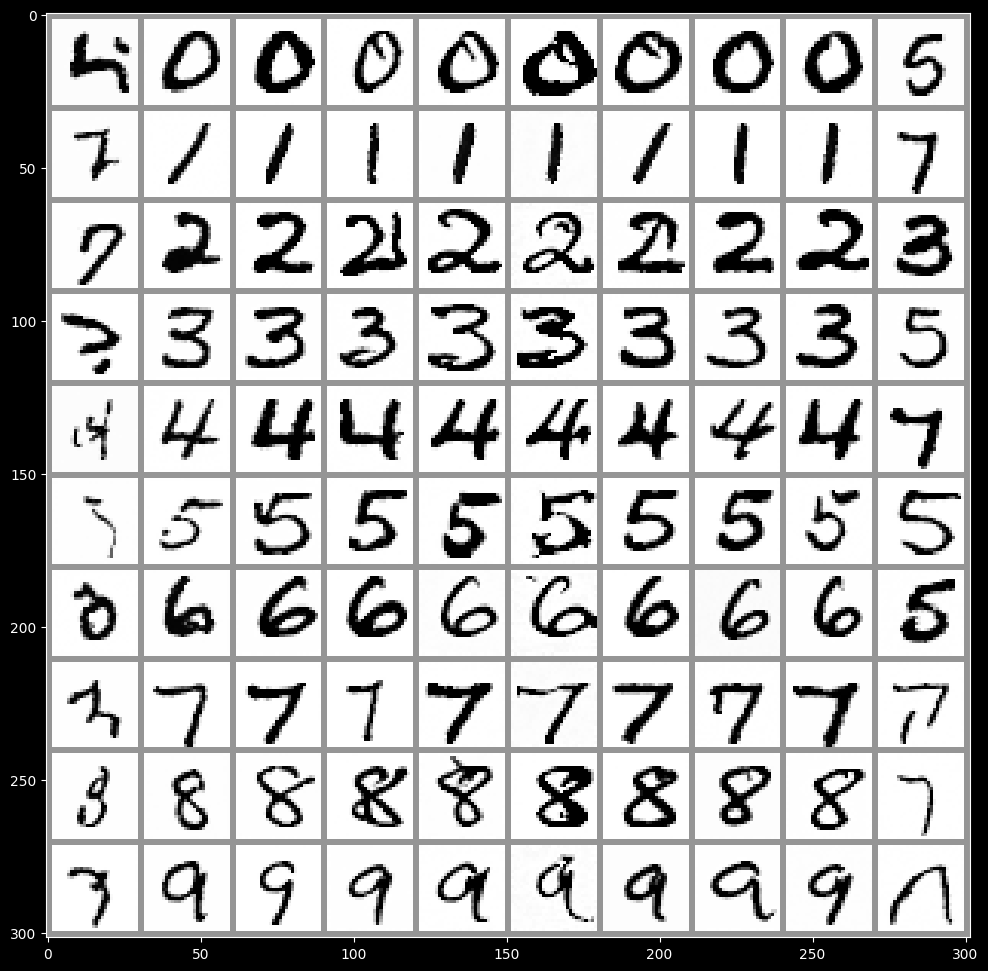

In [12]:
# sampling

guidance_scale = torch.tensor([0.5, 2, 7.5, 10, 20, 40, 7.5, 7.5, 7.5, 7.5])
guidance_scale = guidance_scale[:, None, None, None].to(device)
num_images = 10

# the generated images
outputs = torch.empty((100, 1, 28, 28))

modelC = modelC.to(device)

# Sampling loop
for i in tqdm(range(10)):

    prompt = [f"a handwritten digit {i}"] * 9
    prompt.append(f"a MNIST digit {i}")

    # Tokenize and encode the text prompt
    text_toks = tokenizer(prompt, padding="max_length", max_length=8, truncation=True, return_tensors="pt")
    text_embeddings = encoder(text_toks.input_ids.to(device))[0]

    # Prepare unconditioned embeddings for classifier free guidance
    max_length = text_toks.input_ids.shape[-1]
    uncond_toks= tokenizer([""] * num_images, padding="max_length", max_length=8, return_tensors="pt")
    uncond_embeddings = encoder(uncond_toks.input_ids.to(device))[0]

    # Concatenate text embeddings with unconditional embeddings
    text_embeddings = torch.cat([text_embeddings, uncond_embeddings])
    print(text_embeddings.shape)

    # Initialize latents
    x = torch.randn((num_images, 1, 28, 28)).to(device)

    for t in tqdm(scheduler.timesteps):
        # Expand latents for classifier free guidance
        latent_model_input = torch.cat([x, x])
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # Predict noise residual
        with torch.no_grad():
            noise_pred = modelC.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform guidance
        noise_pred_text , noise_pred_uncond = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Compute previous noisy sample
        x = scheduler.step(noise_pred, t, x).prev_sample
    
    
    # x =generate_image(prompt, num_images=10)
    
    outputs[i*10: i*10+10,:,:,:] = x

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(make_grid(outputs.detach().cpu().clip(-1, 1), nrow=10)[0], cmap='Greys')